<a href="https://colab.research.google.com/github/Roby290597/nlp_exercise/blob/main/bundestags_reden_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os 
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import requests
from sentence_transformers import SentenceTransformer
import numpy as np  
import sys

In [7]:
import sys
from pathlib import Path

extr = next((str(p/"extr") for p in [Path.cwd()] + list(Path.cwd().parents) if (p/"extr").is_dir()), None)
if extr and extr not in sys.path:
    sys.path.insert(0, extr)
print("extr hinzugefügt zu sys.path:", extr)

from redner_extraction import extract_speeches, extract_all_speakers, get_average_sentiment


extr hinzugefügt zu sys.path: c:\Users\brand\OneDrive\Desktop\AI_Selbststudium\ML_little\bundestag_reden\extr


Device set to use cpu


### Extraction of bundestag data  

In [8]:
# Füge Parent-Dir von `extr` zu sys.path hinzu, damit z.B. config.yaml gefunden werden kann
parent_dir = str(Path(extr).parent)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print("Parent-Dir hinzugefügt zu sys.path:", parent_dir)

print(os.listdir(parent_dir))


import yaml
# Load YAML data
with open(parent_dir + "\\config.yaml", "r") as file:
    data = yaml.safe_load(file)  # safe_load prevents arbitrary code execution

# Modify data (optional)
url = data['data']["xml_file"]

Parent-Dir hinzugefügt zu sys.path: c:\Users\brand\OneDrive\Desktop\AI_Selbststudium\ML_little\bundestag_reden
['.git', '.gitignore', 'config.yaml', 'extr', 'figures', 'README.md', 'requirements.txt', 'results', 'src', 'ToDo.txt', 'train', 'web_ui']


In [9]:
#url = "https://www.bundestag.de/resource/blob/1115000/21032.xml" ### Bundestag Reden XML Datei vom November 2025 (Stand 30. November 2025 war es das aktuellste)
response = requests.get(url)

# XML in einen Tree parsen
tree = ET.ElementTree(ET.fromstring(response.content))

# Wurzel-Element abrufen
root = tree.getroot()

In [10]:
reden = {}
redner = []
# Beispiel-Ausgabe
for speech in extract_speeches(root):
    #print(f"Redner: {speech['name']}\nRede: {speech['text'][:200]}...\n")
    if speech['name'] not in redner:
        redner.append(speech['name'])
        reden[speech['name']] = speech['text']
    else:
        print("DOPPELT:", speech['name'])
        reden[speech['name']] += "\n Nächste Rede:" + speech['text']

DOPPELT: Mandy Eißing
DOPPELT: Peter Bohnhof
DOPPELT: Mahmut Özdemir
DOPPELT: Klaus Wiener
DOPPELT: Mirze Edis


In [11]:
redner_party = []
all_speakers = extract_all_speakers(root)
for speaker in all_speakers:
    print(speaker)
    redner_party.append((speaker['vorname'] + " " + speaker['nachname'], speaker['fraktion']))

{'vorname': 'Bärbel', 'nachname': 'Bas', 'fraktion': '', 'rolle_kurz': 'Bundesministerin BMAS'}
{'vorname': 'Hans-Jürgen', 'nachname': 'Goßner', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Wilfried', 'nachname': 'Oellers', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Ricarda', 'nachname': 'Lang', 'fraktion': 'BÜNDNIS\xa090/DIE GRÜNEN', 'rolle_kurz': ''}
{'vorname': 'Pascal', 'nachname': 'Meiser', 'fraktion': 'Die Linke', 'rolle_kurz': ''}
{'vorname': 'Dagmar', 'nachname': 'Schmidt', 'fraktion': 'SPD', 'rolle_kurz': ''}
{'vorname': 'Peter', 'nachname': 'Bohnhof', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Sandra', 'nachname': 'Carstensen', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Armin', 'nachname': 'Grau', 'fraktion': 'BÜNDNIS\xa090/DIE GRÜNEN', 'rolle_kurz': ''}
{'vorname': 'Nora', 'nachname': 'Seitz', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Leif-Erik', 'nachname': 'Holm', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Peter', 'nachn

In [12]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("summarization", model="Shahm/t5-small-german")



Device set to use cpu


In [17]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name = "Shahm/t5-small-german"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [13]:
from transformers import pipeline

# using pipeline API for summarization task
#summarization = pipeline("summarization", model=, tokenizer="t5-small", max_length=1100, min_length=700) # first model tried
summarization = pipeline("summarization", model=model, tokenizer=tokenizer)

# Just an example text in German
original_text = """

Sehr geehrte/r Frau/Herr [Name],

mit großem Interesse bewerbe ich mich als Bankkaufmann in Ihrem Haus. Ich möchte meine Stärke
 im kundenorientierten Arbeiten, meine Sorgfalt im Umgang mit finanziellen Themen sowie meine 
 Freude an Beratung und Vertrieb in Ihre Filiale/Ihr Team einbringen.
In meiner bisherigen Tätigkeit/ Ausbildung zum Bankkaufmann habe ich Privatkundinnen und -kunden 
im täglichen Bankgeschäft betreut – von Kontoführung und Zahlungsverkehr über Service- und 
Beratungsgespräche bis hin zur Terminvorbereitung für komplexere Finanzthemen. Dabei war mir wichtig, 
verständlich zu kommunizieren, Bedürfnisse sauber zu erfassen und Lösungen zuverlässig umzusetzen.
Besonders schätze ich die Kombination aus persönlicher Beratung, strukturierten Prozessen und 
verantwortungsvollem Arbeiten.
Ich arbeite gewissenhaft, diskret und belastbar – auch bei hohem Kundenaufkommen. 
Gleichzeitig bringe ich Teamgeist mit und lege Wert auf eine saubere Dokumentation 
sowie die Einhaltung regulatorischer Vorgaben. Den Umgang mit gängigen Bank-/Office-Systemen 
beherrsche ich sicher und arbeite mich schnell in neue Tools ein.
Gern überzeuge ich Sie in einem persönlichen Gespräch von meiner Motivation und Eignung. 
Ich freue mich über Ihre Rückmeldung.
Mit freundlichen Grüßen.
Max Mustermann
"""

print(len(original_text))

summary_text = summarization(original_text)[0]['summary_text']
print(summary_text)


from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(original_text, summary_text)
print("ROUGE Scores:", scores)

Device set to use cpu


1308
Sehr geehrte/r Frau/Herr, mit großem Interesse bewerbe ich mich als Bankkaufmann in Ihrem Haus.
ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.08854166666666667, fmeasure=0.16267942583732056), 'rougeL': Score(precision=1.0, recall=0.08854166666666667, fmeasure=0.16267942583732056)}


In [14]:
summary_text = summarization(reden["Leif-Erik Holm"][1000:2000])[0]['summary_text']
print("Summary:", summary_text)

Summary: Die Verbandschefin Ostermann ist bitter enttäuscht von dieser Pinocchio-Regierung. Kanzler Merz ist vom Hoffnungsträger zum Bestatter der deutschen Wirtschaft mutiert, zum kleinen und mittleren Unternehmen, die nicht in der Lage sind, Tariflöhne zu zahlen.


## Calcutation of the rouge score 


A description of the rouge_score is given on this website: https://spotintelligence.com/2024/08/12/rouge-metric-in-nlp/


The rouge score describes how similar the summary is to the original text, given as precision, recall and f1-score


In [15]:
from rouge_score import rouge_scorer

# Initialisierung des Scorers 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL', 'rougeLsum'], use_stemmer=True)



precisions_r1 = []
recalls_r1 = []
f1s_r1 = []



precisions_rL = []
recalls_rL = []
f1s_rL = []
length_ratios = []

for name, text in reden.items():
    summary_text = summarization(text)[0]['summary_text']
    scores = scorer.score(text, summary_text)
    print(f"Redner: {name}\nZusammenfassung: {summary_text} ")
    print(f"ratio of the summarized text to the original: {len(summary_text)/len(text)}")
    print("ROUGE Scores:", scores["rouge1"])
    # Rouge-1 Scores speichern
    precisions_r1.append(scores["rouge1"].precision)
    recalls_r1.append(scores["rouge1"].recall)
    f1s_r1.append(scores["rouge1"].fmeasure)
    # Rouge-L Scores speichern
    precisions_rL.append(scores["rougeL"].precision)
    recalls_rL.append(scores["rougeL"].recall)
    f1s_rL.append(scores["rougeL"].fmeasure)
    # Längenverhältnis speichern
    length_ratios.append(len(summary_text)/len(text))

Token indices sequence length is longer than the specified maximum sequence length for this model (958 > 512). Running this sequence through the model will result in indexing errors


Redner: Bärbel Bas
Zusammenfassung: Liebe Kolleginnen und Kollegen! 500 Milliarden Euro - noch nie hat eine Bundesregierung so viel Geld in die Hand genommen, um unser Land voranzubringen. Wir investieren in Kitas, in Schulen, in Krankenhäuser, in Klimaschutz. 
ratio of the summarized text to the original: 0.05705552725420275
ROUGE Scores: Score(precision=1.0, recall=0.05723905723905724, fmeasure=0.10828025477707007)
Redner: Hans-Jürgen Goßner
Zusammenfassung: Die Bundesregierung bastelt ein Gesetz, das angeblich für Fairness sorgen soll, in Wahrheit aber vor allem eins ist: ein Bürokratiemonster, das Betriebe gängelt, Unternehmer misstrauisch beäugt und Beamtenstellen sichert. 
ratio of the summarized text to the original: 0.04603207665069777
ROUGE Scores: Score(precision=1.0, recall=0.04423592493297587, fmeasure=0.0847240051347882)
Redner: Wilfried Oellers
Zusammenfassung: Sehr geehrte Frau Präsidentin! Liebe Kolleginnen und Kollegen! Meine sehr geehrten Damen und Herren! Heute berat

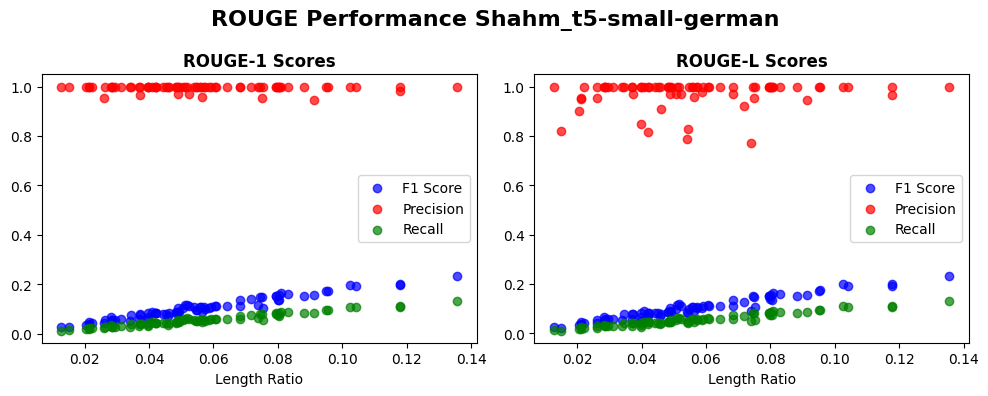

In [47]:
import matplotlib.pyplot as plt

new_model_name = model_name.replace("/", "_")


fig,  ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(length_ratios, f1s_r1, color='blue', alpha=0.7, label='F1 Score')        
ax[0].scatter(length_ratios, precisions_r1, color='red', alpha=0.7, label='Precision')
ax[0].scatter(length_ratios, recalls_r1, color='green', alpha=0.7, label='Recall')
ax[0].set_title('ROUGE-1 Scores', fontweight='bold')
ax[0].set_xlabel('Length Ratio')        
ax[0].legend()      

ax[1].scatter(length_ratios, f1s_rL, color='blue', alpha=0.7, label='F1 Score')        
ax[1].scatter(length_ratios, precisions_rL, color='red', alpha  =0.7, label='Precision')
ax[1].scatter(length_ratios, recalls_rL, color='green', alpha=0.7, label='Recall')
ax[1].set_title('ROUGE-L Scores', fontweight='bold')
ax[1].set_xlabel('Length Ratio')
ax[1].legend()

plt.suptitle(f"ROUGE Performance {new_model_name}", size =16, fontweight='bold')
#plt.text(0.1, -0.5, 'Length Ratio (Summary Length / Original Length)', ha='center', fontsize=5)
plt.tight_layout()
plt.savefig(f"rouge_performance_with_{new_model_name}.png")
plt.show()



In [ ]:
from rouge_score import rouge_scorer


senetence1 = "The quick brown fox jumps on the dog !"
senetence2 = "The quick brown fox jumps on the dog."

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)
scores = scorer.score(senetence1, senetence2)




from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)


prefix = "summarize: "


{'rouge1': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8),
 'rouge2': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778),
 'rougeL': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)}

In [ ]:
from torchmetrics.text.bert import BERTScore


senetence1 = "The quick brown fox jumps on the dog !"
senetence2 = "The quick brown fox jumps on the dog."

bertscore = BERTScore()

print(bertscore([senetence1], [senetence2]))



In [50]:
from datasets import load_dataset


prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.9)
tokenized_billsum = billsum.map(preprocess_function, batched=True)

Map: 100%|██████████| 1114/1114 [00:02<00:00, 475.21 examples/s]


In [ ]:
billsum = load_dataset("billsum", split="ca_test")

In [ ]:
billsum = billsum.train_test_split(test_size=0.999)

tokenized_billsum = billsum.map(preprocess_function, batched=True)

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'

In [1]:
from datasets import load_dataset

ds = load_dataset("reciTAL/mlsum", "de", split="train", streaming=True)

for i, ex in enumerate(ds.take(5), start=1):
    print(f"\n--- Sample {i} ---")
    print("Keys:", list(ex.keys()))
    print("Text:", (ex.get("text","")[:300] + "…") if ex.get("text") else None)
    print("Summary:", (ex.get("summary","")[:300] + "…") if ex.get("summary") else None)



c:\Users\brand\anaconda3\envs\job\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\brand\anaconda3\envs\job\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\brand\.cache\huggingface\hub\datasets--reciTAL--mlsum. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode

RuntimeError: Dataset scripts are no longer supported, but found mlsum.py

In [2]:
from datasets import get_dataset_config_names
print(get_dataset_config_names("reciTAL/mlsum"))


RuntimeError: Dataset scripts are no longer supported, but found mlsum.py